In [1]:
#importing the required stuff
from qiskit import Aer
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import *
from qiskit_finance import QiskitFinanceError
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import OptimizationApplication
from qiskit_optimization.converters import QuadraticProgramToQubo
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import csv
import yfinance as yf
import pandas_datareader.data as web


In [2]:
%matplotlib inline

In [3]:
# set number of assets (= number of qubits)
num_assets = 4
seed = 1234


start = datetime.datetime(2011, 1, 1)
end = datetime.datetime(2015, 12, 1)

df = web.DataReader(["JPM", "GS", "MSFT", "AAPL"],'yahoo', start, end)
df.to_csv(r'C:\Users\shrey\Documents\stockdata1.csv')
print (df)

# Using data from yahoo finance
# use the name listed for particular company that you wish to add
data = YahooDataProvider(
        tickers= ["JPM", "GS", "MSFT", "AAPL"],
        start=datetime.datetime(2015, 1, 1),
        end=datetime.datetime(2021, 12, 1),
    )

data.run()

mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()

Attributes  Adj Close                                        Close  \
Symbols           JPM          GS       MSFT       AAPL        JPM   
Date                                                                 
2010-12-31  30.822552  139.064880  21.863089   9.836143  42.419998   
2011-01-03  31.665409  143.108780  21.917933  10.049909  43.580002   
2011-01-04  32.123703  143.133652  22.004095  10.102356  44.160000   
2011-01-05  32.516525  143.894409  21.933596  10.184992  44.700001   
2011-01-06  32.356472  142.414154  22.575935  10.176762  44.480000   
...               ...         ...        ...        ...        ...   
2015-11-24  55.353794  166.308685  48.774662  27.253246  66.779999   
2015-11-25  55.420086  166.731796  48.271179  27.058390  66.860001   
2015-11-27  55.677048  167.895401  48.486958  27.007954  67.169998   
2015-11-30  55.270901  168.072281  48.864571  27.120277  66.680000   
2015-12-01  56.041767  170.770035  49.646763  26.900206  67.610001   

Attributes         

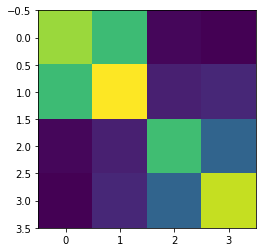

In [4]:
# plot sigma
plt.imshow(sigma, interpolation="nearest")
plt.show()


In [5]:
q = 0.5  # set risk factor
budget = num_assets // 4 # set budget
penalty = num_assets  # set parameter to scale the budget penalty term

portfolio = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget
)
qp = portfolio.to_quadratic_program()
qp

<QuadraticProgram: minimize 0.0001603047796283253*x_0^2 + 0.000286804079558232..., 4 variables, 1 constraints, 'Portfolio optimization'>

In [6]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i] == "1" else 0 for i in reversed(range(num_assets))])
    return x


def print_result(result,fname):
    
    f = open(fname, 'w')
    header = ['SELECTION', 'VALUE', 'PROBABLITY']
    writer = csv.writer(f)
    writer.writerow(header)
    
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    probabilities = np.abs(eigenvector) ** 2
    i_sorted = reversed(np.argsort(probabilities))
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
        # value = portfolio.to_quadratic_program().objective.evaluate(x)
        probability = probabilities[i]
        row = [x, value, probability]
        writer.writerow(row)
        print("%10s\t%.4f\t\t%.4f" % (x, value, probability))
    f.close()

In [7]:
#classical reference solution
#provide fname ='complete address/location of your .csv file'


exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)
fname = (r'C:\Users\shrey\Documents\stockdata1.csv') #change the location and nsame of .csv file

print_result(result,fname)

Optimal: selection [0. 0. 1. 0.], value -0.0012

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [0 0 1 0]	-0.0012		1.0000
 [1 1 1 1]	9.0499		0.0000
 [0 1 1 1]	4.0210		0.0000
 [1 0 1 1]	4.0208		0.0000
 [0 0 1 1]	1.0037		0.0000
 [1 1 0 1]	4.0216		0.0000
 [0 1 0 1]	1.0044		0.0000
 [1 0 0 1]	1.0042		0.0000
 [0 0 0 1]	-0.0011		0.0000
 [1 1 1 0]	4.0215		0.0000
 [0 1 1 0]	1.0043		0.0000
 [1 0 1 0]	1.0041		0.0000
 [1 1 0 0]	1.0050		0.0000
 [0 1 0 0]	-0.0005		0.0000
 [1 0 0 0]	-0.0006		0.0000
 [0 0 0 0]	1.0058		0.0000


Using dataframes and pandas to extract data from the output and converting it into list and dict

In [44]:
#optional step, can be skipped
import pandas as pd

df = pd.read_csv(r'C:\Users\shrey\Documents\stockdata1.csv')
print(df)

    SELECTION     VALUE  PROBABLITY
0   [0 0 1 0] -0.001201         1.0
1   [1 1 1 1]  9.049937         0.0
2   [0 1 1 1]  4.021003         0.0
3   [1 0 1 1]  4.020772         0.0
4   [0 0 1 1]  1.003725         0.0
5   [1 1 0 1]  4.021615         0.0
6   [0 1 0 1]  1.004429         0.0
7   [1 0 0 1]  1.004213         0.0
8   [0 0 0 1] -0.001086         0.0
9   [1 1 1 0]  4.021500         0.0
10  [0 1 1 0]  1.004310         0.0
11  [1 0 1 0]  1.004103         0.0
12  [1 1 0 0]  1.004990         0.0
13  [0 1 0 0] -0.000452         0.0
14  [1 0 0 0] -0.000645         0.0
15  [0 0 0 0]  1.005800         0.0


In [63]:
# importing the module
import csv
 
# open the file in read mode
filename = open(r'C:\Users\shrey\Documents\stockdata1.csv')
 
# creating dictreader object
file = csv.DictReader(filename)
 
# creating empty lists
SELECTION = []
VALUE = []
PROBABILITY = []
 
# iterating over each row and append
# values to empty list
for col in file:
    SELECTION.append(col['SELECTION'])
    VALUE.append(col['VALUE'])
    PROBABILITY.append(col['PROBABLITY'])
 
# printing lists
print('SELECTION:', SELECTION)
print('VALUE:', VALUE)
print('PROBABLITY:', PROBABILITY)

SELECTION: ['[0 0 1 0]', '[1 1 1 1]', '[0 1 1 1]', '[1 0 1 1]', '[0 0 1 1]', '[1 1 0 1]', '[0 1 0 1]', '[1 0 0 1]', '[0 0 0 1]', '[1 1 1 0]', '[0 1 1 0]', '[1 0 1 0]', '[1 1 0 0]', '[0 1 0 0]', '[1 0 0 0]', '[0 0 0 0]']
VALUE: ['-0.001200566265928238', '9.049937078406549', '4.021002801978017', '4.020772281019', '1.003724702798685', '4.021615351436882', '1.0044293804855098', '1.0042132603605705', '-0.0010860123825828794', '4.021500178319665', '1.0043102427863948', '1.0041026710591243', '1.0049896798615237', '-0.0004519501945858817', '-0.0006451210877789215', '1.0057999470643304']
PROBABLITY: ['1.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0']


In [64]:
df1 = pd.DataFrame(SELECTION)
df2 = pd.DataFrame(VALUE)
df3 = pd.DataFrame(PROBABILITY)
print(df1)
print(df2)
print(df3)

            0
0   [0 0 1 0]
1   [1 1 1 1]
2   [0 1 1 1]
3   [1 0 1 1]
4   [0 0 1 1]
5   [1 1 0 1]
6   [0 1 0 1]
7   [1 0 0 1]
8   [0 0 0 1]
9   [1 1 1 0]
10  [0 1 1 0]
11  [1 0 1 0]
12  [1 1 0 0]
13  [0 1 0 0]
14  [1 0 0 0]
15  [0 0 0 0]
                         0
0    -0.001200566265928238
1        9.049937078406549
2        4.021002801978017
3           4.020772281019
4        1.003724702798685
5        4.021615351436882
6       1.0044293804855098
7       1.0042132603605705
8   -0.0010860123825828794
9        4.021500178319665
10      1.0043102427863948
11      1.0041026710591243
12      1.0049896798615237
13  -0.0004519501945858817
14  -0.0006451210877789215
15      1.0057999470643304
      0
0   1.0
1   0.0
2   0.0
3   0.0
4   0.0
5   0.0
6   0.0
7   0.0
8   0.0
9   0.0
10  0.0
11  0.0
12  0.0
13  0.0
14  0.0
15  0.0


In [69]:
# conversion of lists to dictionary
# using dictionary comprehension

# Printing original keys-value lists
print ("Selection" + str(SELECTION))
print ("Value" + str(VALUE))

# using dictionary comprehension
# to convert lists to dictionary
res = {SELECTION[i]: VALUE[i] for i in range(len(VALUE))}

# Printing resultant dictionary
print ("Resultant dictionary is : " + str(res))


Selection['[0 0 1 0]', '[1 1 1 1]', '[0 1 1 1]', '[1 0 1 1]', '[0 0 1 1]', '[1 1 0 1]', '[0 1 0 1]', '[1 0 0 1]', '[0 0 0 1]', '[1 1 1 0]', '[0 1 1 0]', '[1 0 1 0]', '[1 1 0 0]', '[0 1 0 0]', '[1 0 0 0]', '[0 0 0 0]']
Value['-0.001200566265928238', '9.049937078406549', '4.021002801978017', '4.020772281019', '1.003724702798685', '4.021615351436882', '1.0044293804855098', '1.0042132603605705', '-0.0010860123825828794', '4.021500178319665', '1.0043102427863948', '1.0041026710591243', '1.0049896798615237', '-0.0004519501945858817', '-0.0006451210877789215', '1.0057999470643304']
Resultant dictionary is : {'[0 0 1 0]': '-0.001200566265928238', '[1 1 1 1]': '9.049937078406549', '[0 1 1 1]': '4.021002801978017', '[1 0 1 1]': '4.020772281019', '[0 0 1 1]': '1.003724702798685', '[1 1 0 1]': '4.021615351436882', '[0 1 0 1]': '1.0044293804855098', '[1 0 0 1]': '1.0042132603605705', '[0 0 0 1]': '-0.0010860123825828794', '[1 1 1 0]': '4.021500178319665', '[0 1 1 0]': '1.0043102427863948', '[1 0 1 

In [76]:
#sorting 
acen = sorted(res.items(), key=lambda x: x[1])
print(acen)

[('[0 1 0 0]', '-0.0004519501945858817'), ('[1 0 0 0]', '-0.0006451210877789215'), ('[0 0 0 1]', '-0.0010860123825828794'), ('[0 0 1 0]', '-0.001200566265928238'), ('[0 0 1 1]', '1.003724702798685'), ('[1 0 1 0]', '1.0041026710591243'), ('[1 0 0 1]', '1.0042132603605705'), ('[0 1 1 0]', '1.0043102427863948'), ('[0 1 0 1]', '1.0044293804855098'), ('[1 1 0 0]', '1.0049896798615237'), ('[0 0 0 0]', '1.0057999470643304'), ('[1 0 1 1]', '4.020772281019'), ('[0 1 1 1]', '4.021002801978017'), ('[1 1 1 0]', '4.021500178319665'), ('[1 1 0 1]', '4.021615351436882'), ('[1 1 1 1]', '9.049937078406549')]


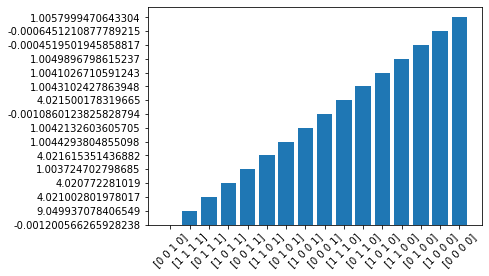

In [87]:
#Test ignore (for my ref)
plt.bar(range(len(acen)), VALUE, tick_label=SELECTION)
plt.xticks(rotation = 45)
plt.show()

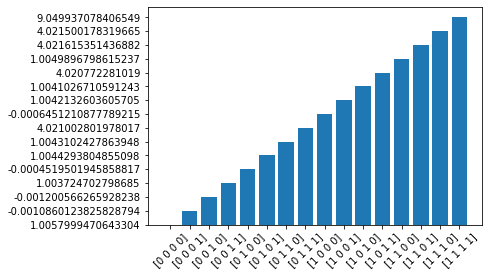

In [92]:
import matplotlib.pylab as plt

lists = sorted(res.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.bar(x, y)
plt.xticks(rotation = 45)
plt.show()

In [11]:
# VQE solution
#provide fname ='complete address/location of your .csv file'


from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
quantum_instance = QuantumInstance(backend=backend, shots=8192, seed_simulator=seed, seed_transpiler=seed)
vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)
result = vqe.solve(qp)

fname = (r'C:\Users\shrey\Documents\stockdata1.1.csv') #change the location and name of .csv file
print_result(result, fname)


Optimal: selection [0. 0. 0. 1.], value -0.0011

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [0 1 0 0]	-0.0005		0.8784
 [0 0 0 1]	-0.0011		0.1169
 [1 0 0 0]	-0.0006		0.0047
 [0 0 1 0]	-0.0012		0.0000
 [1 0 1 1]	4.0208		0.0000
 [0 0 1 1]	1.0037		0.0000
 [1 1 0 0]	1.0050		0.0000
 [1 1 1 0]	4.0215		0.0000
 [1 0 1 0]	1.0041		0.0000
 [0 1 1 0]	1.0043		0.0000
 [1 0 0 1]	1.0042		0.0000
 [1 1 1 1]	9.0499		0.0000
 [0 0 0 0]	1.0058		0.0000
 [0 1 1 1]	4.0210		0.0000
 [1 1 0 1]	4.0216		0.0000
 [0 1 0 1]	1.0044		0.0000


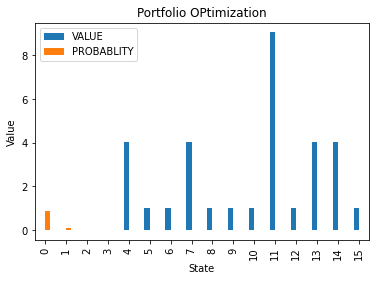

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(r'C:\Users\shrey\Documents\stockdata1.1.csv')

df.plot(kind = 'bar')
plt.xlabel('State')
plt.ylabel('Value')
plt.title('Portfolio OPtimization')
plt.legend()
plt.show()


In [13]:
# QAOA solution
#provide fname ='complete address/location of your .csv file'


algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
quantum_instance = QuantumInstance(backend=backend, shots=8192, seed_simulator=seed, seed_transpiler=seed)
qaoa_mes = QAOA(optimizer=cobyla, reps=3, quantum_instance=quantum_instance)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

fname = (r'C:\Users\shrey\Documents\stockdata1.2.csv') #change the location and name of .csv file
print_result(result, fname)


Optimal: selection [0. 0. 1. 0.], value -0.0012

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [0 1 0 0]	-0.0005		0.2047
 [1 0 0 0]	-0.0006		0.2044
 [0 0 0 1]	-0.0011		0.2037
 [0 0 1 0]	-0.0012		0.2036
 [0 0 0 0]	1.0058		0.0343
 [1 1 0 0]	1.0050		0.0230
 [0 1 0 1]	1.0044		0.0228
 [0 1 1 0]	1.0043		0.0227
 [1 0 0 1]	1.0042		0.0227
 [1 0 1 0]	1.0041		0.0226
 [0 0 1 1]	1.0037		0.0224
 [1 1 1 1]	9.0499		0.0029
 [1 1 0 1]	4.0216		0.0026
 [1 1 1 0]	4.0215		0.0026
 [0 1 1 1]	4.0210		0.0025
 [1 0 1 1]	4.0208		0.0025


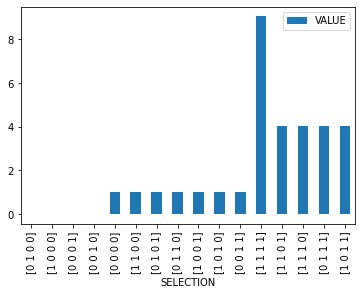

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(r'C:\Users\shrey\Documents\stockdata1.2.csv')

df.plot(kind = 'bar', x = 'SELECTION', y = 'VALUE')

plt.show()